Louie Balderrama<br>
Springboard Data Science Career Track, January 2019 cohort<br>

<h1 align="center"> Data Story </h1>

### Austin, TX Map ###
The Airbnb `listings` dataset contains the global coordinate locations of every listing in Austin, TX. Likewise, the `crimes` dataset specifies the location of all the crimes that occurred (and were reported) in Austin, TX in the year 2018. These information aren't part of our final `df` dataset because we have opted to make use of zip codes to categorize the listings' locations. Still, we'll make use of these geographical points to explore our data further through the visualization of maps. We'll make use of the `austin_map` dataframe as the backdrop of our plots. This was derived from the Zip Codes GeoJSON taken from the City of Austin data portal.

In [54]:
austin_map = gpd.read_file("data\Zipcodes.geojson")
austin_map["zipcode"] = austin_map["zipcode"].astype(int)

print(type(austin_map))
display(austin_map.head())

<class 'geopandas.geodataframe.GeoDataFrame'>


,zipcode,name,number_of_records,objectid,zipcodes_id,geometry
0,78702,AUSTIN,45,51,45,"(POLYGON ((-97.69186838400699 30.248482149129,..."
1,78642,LIBERTY HILL,None,26,20,"(POLYGON ((-97.89359001287301 30.782117310707,..."
2,78752,AUSTIN,30,11,5,"(POLYGON ((-97.686347884619 30.332598550963, -..."
3,78747,AUSTIN,25,32,26,"(POLYGON ((-97.73618056605601 30.159870363356,..."
4,78653,MANOR,2,29,23,"(POLYGON ((-97.501494615524 30.477330039287, -..."


### Location and Price ###
We've simplified the classification of Airbnb listings into three types: *Apartment*, *House*, and *Other* – which is the category for the miscellaneous and even quirky listings including RV's, yurts, treehouses, and more.

Below is the plot of all the Austin, TX Airbnb listings categorized by type.

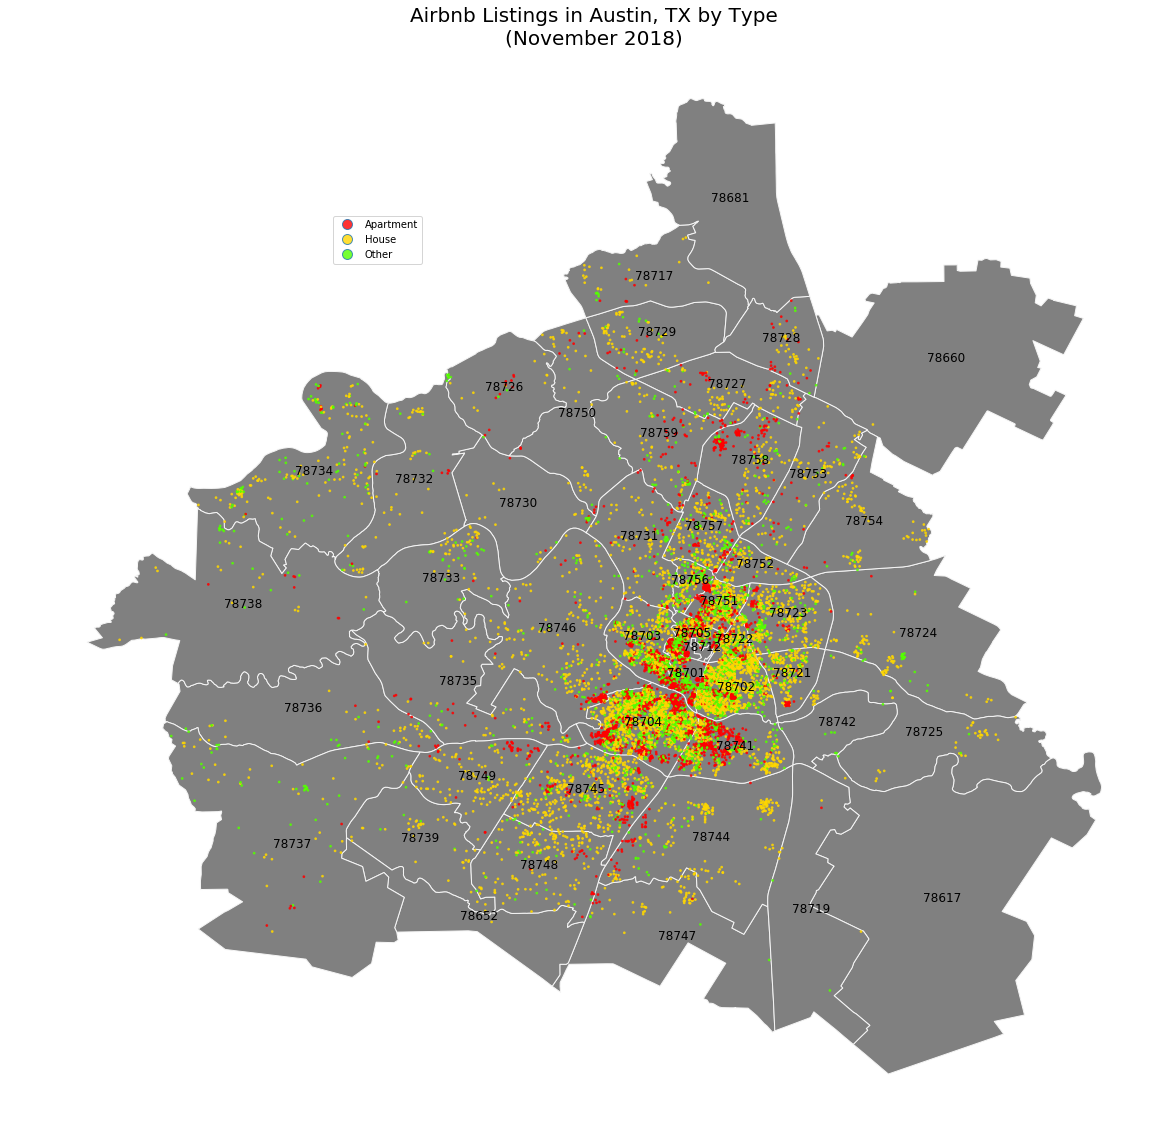

In [55]:
listings_df = pd.merge(listings[["id", "latitude", "longitude"]], \
                       df, how="right", on="id")
listings_df = listings_df[["zipcode", "id", "latitude", "longitude", \
                           "property_type (simple)"]]
listings_df["Point"] = listings_df.apply(lambda row: \
                                         Point(row["longitude"], \
                                               row["latitude"]), axis=1)
listings_df = gpd.GeoDataFrame(listings_df, geometry="Point")

geo_df = listings_df.groupby("zipcode").count()
geo_df = pd.merge(austin_map, geo_df, how="right", on="zipcode")
geo_df = geo_df.set_index("zipcode")

fig, ax = plt.subplots(figsize=(20,20))

base = geo_df.plot(color="grey", \
                   edgecolor="whitesmoke", ax=ax)
geo_df.apply(lambda x: ax.annotate(s=x.name, \
                                   xy=x.geometry.centroid.coords[0], \
                                   ha="center", fontweight="light", \
                                   fontsize=12, color="black"), axis=1)
base.axis("off")

listings_df.plot(ax=base, cmap="prism", marker="o", markersize=3, \
                 alpha=.8, column="property_type (simple)", \
                 categorical=True, legend=True)

legend = ax.get_legend()
legend.set_bbox_to_anchor((0.25, 0.75, 0.10, 0.10))

plt.title("Airbnb Listings in Austin, TX by Type\n(November 2018)", \
          fontdict={"fontsize":20})

plt.show()

From the figure, it was evident that listings are more concentrated within the inner zip codes, and listings begin dwindling and become more scattered as we go outward. We can draw different inferences from this – perhaps more listings suggest a more urban area. Or perhaps the farther out we are, the more regulations are put in place to ward off commercialization of suburban homes.

We can associate the cluster of listings with our main variable, *price*. Below is the plot of all the listings again but this time, on the backdrop of how expensive the zip code is in terms of *average* nightly Airbnb rate. The darker the green is, the more expensive, and the lighter the green is, the more affordable its listings are.

A good hypothesis is that prices should be cheaper in places that are more clustered because the competition should have lowered the price down. At the same time, the counterpoint could just be as likely: that more listings mean higher prices because this suggests more attractions and/or businesses are within close proximity.

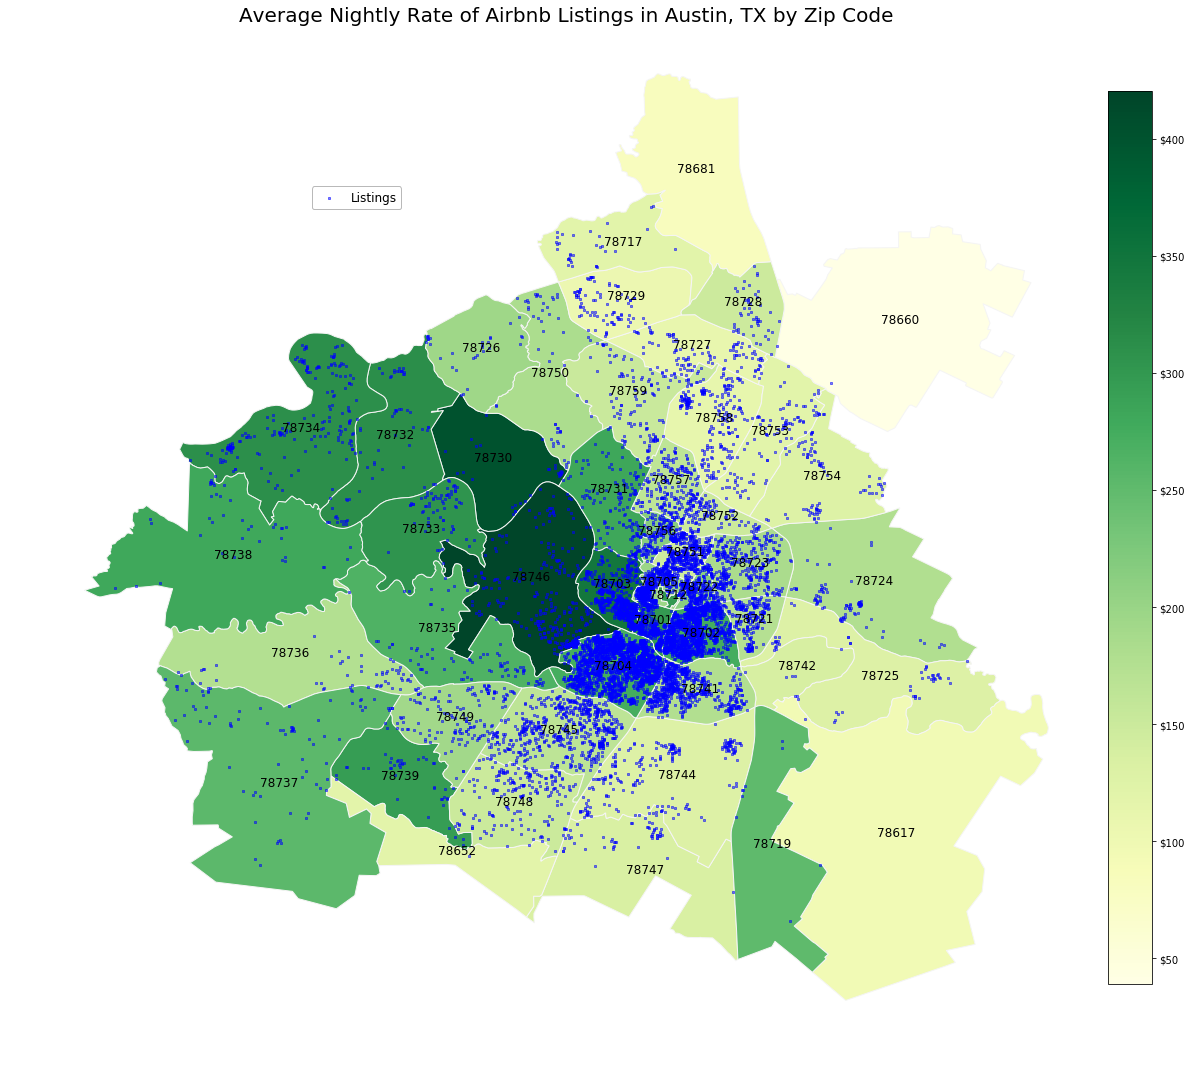

In [56]:
price_df = df.pivot_table(index="zipcode", values="price", aggfunc="mean")
price_df = pd.merge(austin_map, price_df, how="right", on="zipcode")
price_df = price_df.set_index("zipcode")

fig, ax = plt.subplots(figsize=(20,20))

base = price_df.plot(column="price", cmap="YlGn", \
                     edgecolor="whitesmoke", ax=ax)
price_df.apply(lambda x: ax.annotate(s=x.name, \
                                     xy=x.geometry.centroid.coords[0], \
                                     ha="center", fontweight="light", \
                                     fontsize=12, color="black"), axis=1)
base.axis("off")

min_price = price_df["price"].min()
max_price = price_df["price"].max()
gradient = plt.cm.ScalarMappable(cmap="YlGn", \
                                 norm=plt.Normalize(vmin=min_price, \
                                                    vmax=max_price))
gradient._A = []
cbar = fig.colorbar(gradient, fraction=0.04, pad=.01)

listings_df.plot(ax=base, color="blue", marker="s", markersize=1.5, \
                 alpha=.5, label="Listings")

cbar.ax.set_yticklabels(["$" + i.get_text() for i in cbar.ax.get_yticklabels()])

legend = plt.legend(facecolor="w", edgecolor="darkgray", fontsize=12)
legend.set_bbox_to_anchor((0.25, 0.75, 0.10, 0.10))

plt.title("Average Nightly Rate of Airbnb Listings in Austin, TX by Zip Code", \
          fontdict={"fontsize":20})

plt.show()

We see that, indeed, prices are higher in a zip code when there are a higher number of listings, though not exactly. Zip code 78730 is the second darkest area (suggesting the second priciest zip code) but there are only a handful of listings within it. And the opposite is true, in some cases, including 78757 which holds a lot of listings – most of which seem to be affordable according to their mean.

To get a better picture, below is the top 10 most expensive Airbnb zip codes (*in green*) and the top 10 places with the most Airbnb listings (*in blue*). If there is high correlation then we should see a lot of intersections (*in blue-green*).

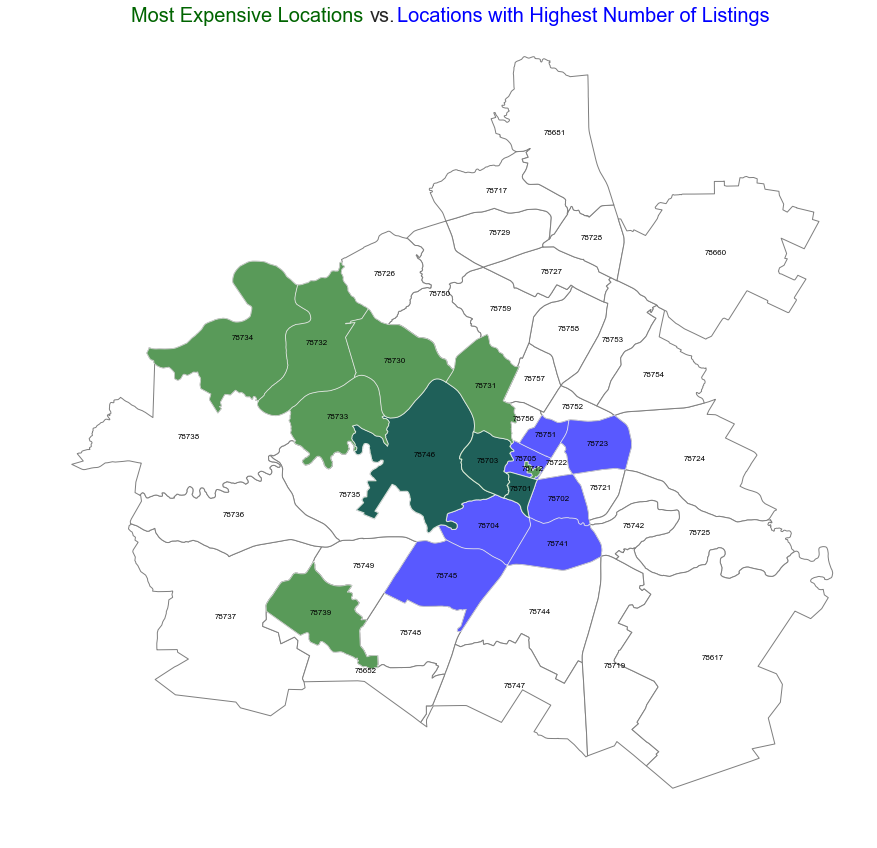

In [79]:
price_df = df.pivot_table(index="zipcode", values="price", aggfunc="mean")
price_df = pd.merge(austin_map, price_df, how="right", on="zipcode")
price_df = price_df.sort_values("price", ascending=False)
price_df = price_df[["zipcode", "geometry", "price"]].set_index("zipcode")

geo_df = listings_df.groupby("zipcode").count()
geo_df = pd.merge(austin_map, geo_df, how="right", on="zipcode")
geo_df = geo_df.sort_values("id", ascending=False)
geo_df = geo_df[["zipcode", "geometry", "id"]].set_index("zipcode")

fig, ax = plt.subplots(figsize=(15,15))

base = geo_df.plot(color="w", \
                   edgecolor="grey", ax=ax)
geo_df.apply(lambda x: ax.annotate(s=x.name, \
                                   xy=x.geometry.centroid.coords[0], \
                                   ha="center", fontweight="light", \
                                   fontsize=8, color="black"), axis=1)
base.axis("off")

geo_df[["geometry", "id"]][0:10].plot(color="blue", alpha=0.65, \
                                      ax=base)

price_df[["geometry", "price"]][0:10].plot(color="darkgreen", \
                                           alpha=0.65, ax=base)

fig.text(0.323, 0.870, "Most Expensive Locations", ha="center", \
         va="bottom", size=20,color="darkgreen")
fig.text(0.448, 0.870, "vs.", ha="center", va="bottom", size=20)
fig.text(0.634, 0.870, "Locations with Highest Number of Listings", \
         ha="center", va="bottom", size=20,color="blue")

plt.show()

There were three places that happen to be in *both* the top 10 most expensive zip codes and the top 10 most clustered. These are 78746, 78703, and 78701.

Another way to intuitively check correlation is to see the flipside of this: below is the top 10 least expensive zip codes and the top 10 locations that have the lowest number of listings.

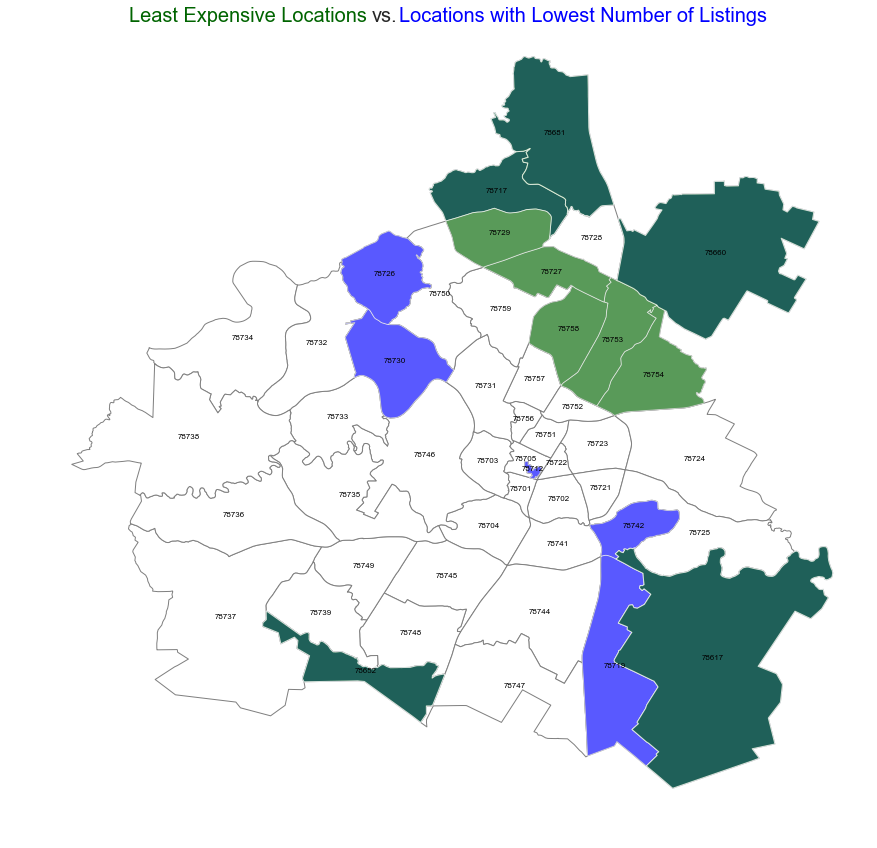

In [80]:
fig, ax = plt.subplots(figsize=(15,15))

base = geo_df.plot(color="w", \
                   edgecolor="grey", ax=ax)
geo_df.apply(lambda x: ax.annotate(s=x.name, \
                                   xy=x.geometry.centroid.coords[0], \
                                   ha="center", fontweight="light", \
                                   fontsize=8, color="black"), axis=1)
base.axis("off")

geo_df[["geometry", "id"]][-10:].plot(color="blue", alpha=0.65, \
                                      ax=base)

price_df[["geometry", "price"]][-10:].plot(color="darkgreen", \
                                           alpha=0.65, ax=base)

fig.text(0.323, 0.870, "Least Expensive Locations", ha="center", \
         va="bottom", size=20,color="darkgreen")
fig.text(0.450, 0.870, "vs.", ha="center", va="bottom", size=20)
fig.text(0.634, 0.870, "Locations with Lowest Number of Listings", \
         ha="center", va="bottom", size=20,color="blue")

plt.show()

This time they are more aligned, with *half* of the samples that intersect. These are 78681, 78717, 78660, 78617, 78652.

It is not clear-cut, but it's safe to say that in very general terms, price do have a relationship with the number of listings in a given area.

### Popularity and Price ###
We also have data on the number of reviews a listing has. We cannot say matter-of-factly that the more reviews a listing gets, the better rated it is. After all, a listing may have thousands of reviews but a majority could be *negative*. What a high number of reviews suggests instead is *popularity*. Popularity here means the same way as how an online retailer would describe a "best-seller". A popular listing just happens to have been more booked.

Below is the plot of the top 100 most reviewed listings in Austin, TX. A good hypothesis here is that the more reviews a listing has, the pricier it is. If so, this could be because popular listings tend to be more attractive. Or perhaps the more guests a host has had, the more experienced the host becomes in terms of hospitality.

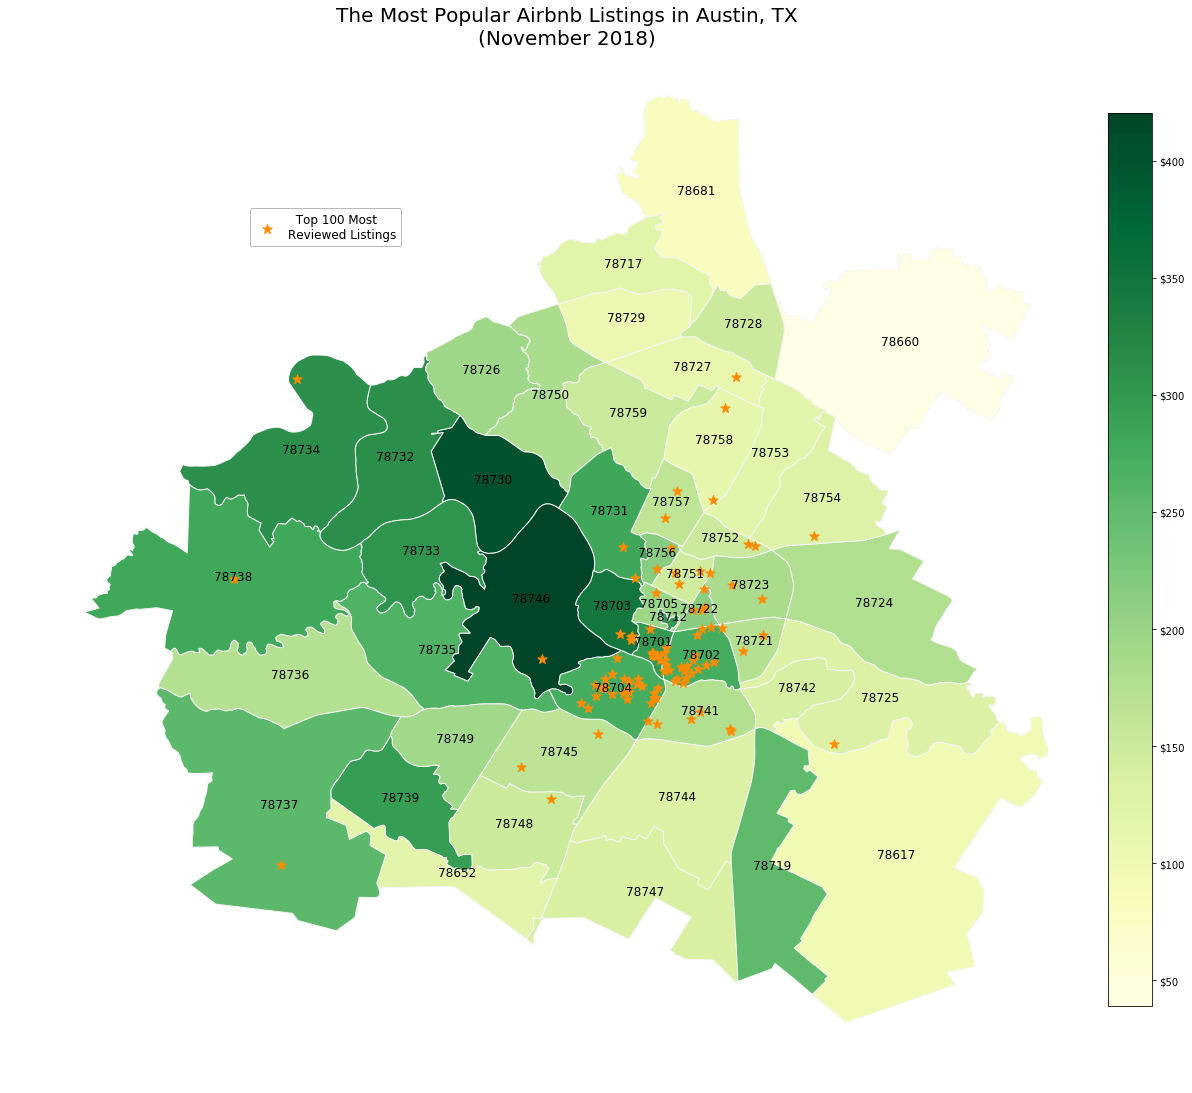

In [59]:
reviews_df = pd.merge(listings[["id", "latitude", "longitude"]], \
                      df, how="right", on="id")
reviews_df = reviews_df[["zipcode", "id", "latitude", "longitude", \
                         "number_of_reviews"]]
reviews_df["Point"] = reviews_df.apply(lambda row: \
                                       Point(row["longitude"], \
                                             row["latitude"]), axis=1)
reviews_df = gpd.GeoDataFrame(reviews_df, geometry="Point")
reviews_df = reviews_df.sort_values("number_of_reviews", ascending=False)
reviews_df = reviews_df.iloc[0:100]

price_df = df.pivot_table(index="zipcode", values="price", aggfunc="mean")
price_df = pd.merge(austin_map, price_df, how="right", on="zipcode")
price_df = price_df.set_index("zipcode")

fig, ax = plt.subplots(figsize=(20,20))

base = price_df.plot(column="price", cmap="YlGn", \
                   edgecolor="whitesmoke", ax=ax)
price_df.apply(lambda x: ax.annotate(s=x.name, \
                                     xy=x.geometry.centroid.coords[0], \
                                     ha="center", fontweight="light", \
                                     fontsize=12, color="black"), axis=1)
base.axis("off")

min_price = price_df["price"].min()
max_price = price_df["price"].max()
gradient = plt.cm.ScalarMappable(cmap="YlGn", \
                                 norm=plt.Normalize(vmin=min_price, \
                                                    vmax=max_price))
gradient._A = []
cbar = fig.colorbar(gradient, fraction=0.04, pad=.01)

reviews_df.plot(ax=base, color="darkorange", marker="*", markersize=100, \
                alpha=1, label="  Top 100 Most\nReviewed Listings")

cbar.ax.set_yticklabels(["$" + i.get_text() for i in cbar.ax.get_yticklabels()])

legend = plt.legend(facecolor="w", edgecolor="darkgray", fontsize=12)
legend.set_bbox_to_anchor((0.25, 0.75, 0.10, 0.10))

plt.title("The Most Popular Airbnb Listings in Austin, TX\n(November 2018)", \
          fontdict={"fontsize":20})

plt.show()

We do see that the most reviewed listings are clustered in areas that tend to be more expensive. But to test this deeper visually, we'll again plot the top 10 most expensive places (*in green*) along with the top 10 most reviewed places (*in orange*) to see if there are any intersections (*in gold*).

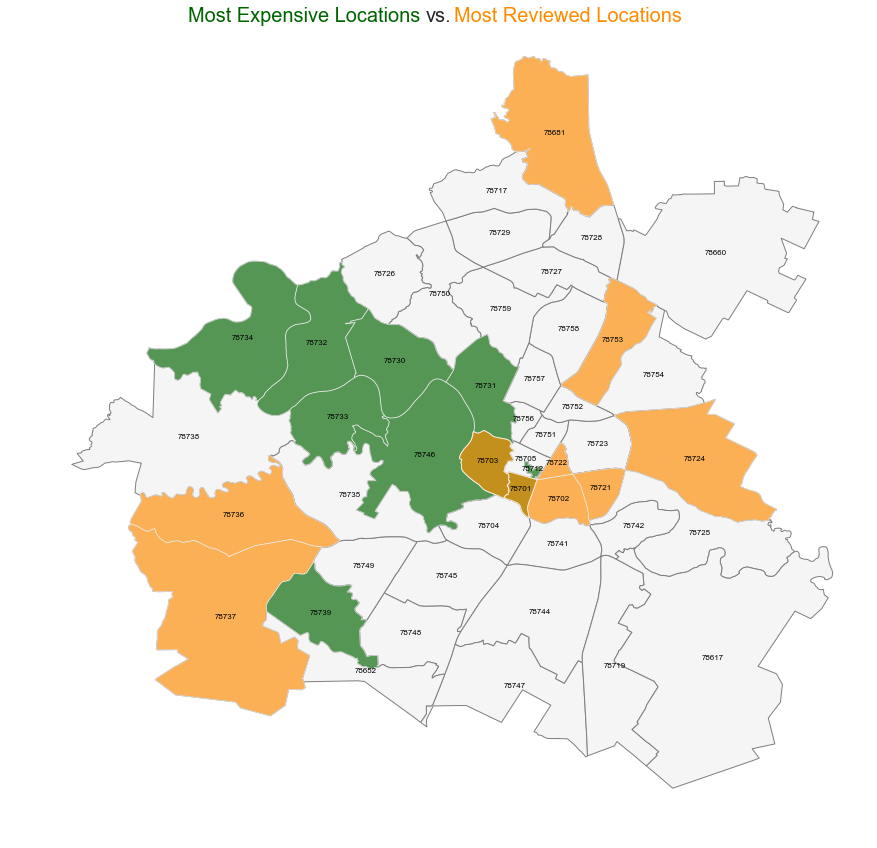

In [81]:
reviews_df = df.pivot_table(index="zipcode", \
                            values="number_of_reviews", aggfunc="mean")
reviews_df = pd.merge(austin_map, reviews_df, how="right", on="zipcode")
reviews_df = reviews_df.sort_values("number_of_reviews", ascending=False)
reviews_df = reviews_df[["zipcode", "geometry", \
                         "number_of_reviews"]].set_index("zipcode")

price_df = df.pivot_table(index="zipcode", \
                          values="price", aggfunc="mean")
price_df = pd.merge(austin_map, price_df, how="right", on="zipcode")
price_df = price_df.sort_values("price", ascending=False)
price_df = price_df[["zipcode", "geometry", "price"]].set_index("zipcode")

geo_df = listings_df.groupby("zipcode").count()
geo_df = pd.merge(austin_map, geo_df, how="right", on="zipcode")
geo_df = geo_df.sort_values("id", ascending=False)
geo_df = geo_df[["zipcode", "geometry", "id"]].set_index("zipcode")

fig, ax = plt.subplots(figsize=(15,15))

base = geo_df.plot(color="whitesmoke", \
                   edgecolor="grey", ax=ax)
geo_df.apply(lambda x: ax.annotate(s=x.name, \
                                   xy=x.geometry.centroid.coords[0], \
                                   ha="center", fontweight="light", \
                                   fontsize=8, color="black"), axis=1)
base.axis("off")

price_df[["geometry", "price"]][0:10].plot(color="darkgreen", alpha=0.65, \
                                           ax=base)

reviews_df[["geometry", "number_of_reviews"]][0:10].plot(color="darkorange", \
                                                         alpha=0.65, ax=base)

fig.text(0.375, 0.870, "Most Expensive Locations", ha="center", \
         va="bottom", size=20,color="darkgreen")
fig.text(0.500, 0.870, "vs.", ha="center", va="bottom", size=20)
fig.text(0.620, 0.870, "Most Reviewed Locations", ha="center", \
         va="bottom", size=20,color="darkorange")

plt.show()

We see that only two of the most expensive zip codes happen to also be the places where the most reviewed listings are. These are 78703 and 78701.

Again, we'll do the opposite and see if the top ten least expensive locations coincide with the top ten least reviewed locations.

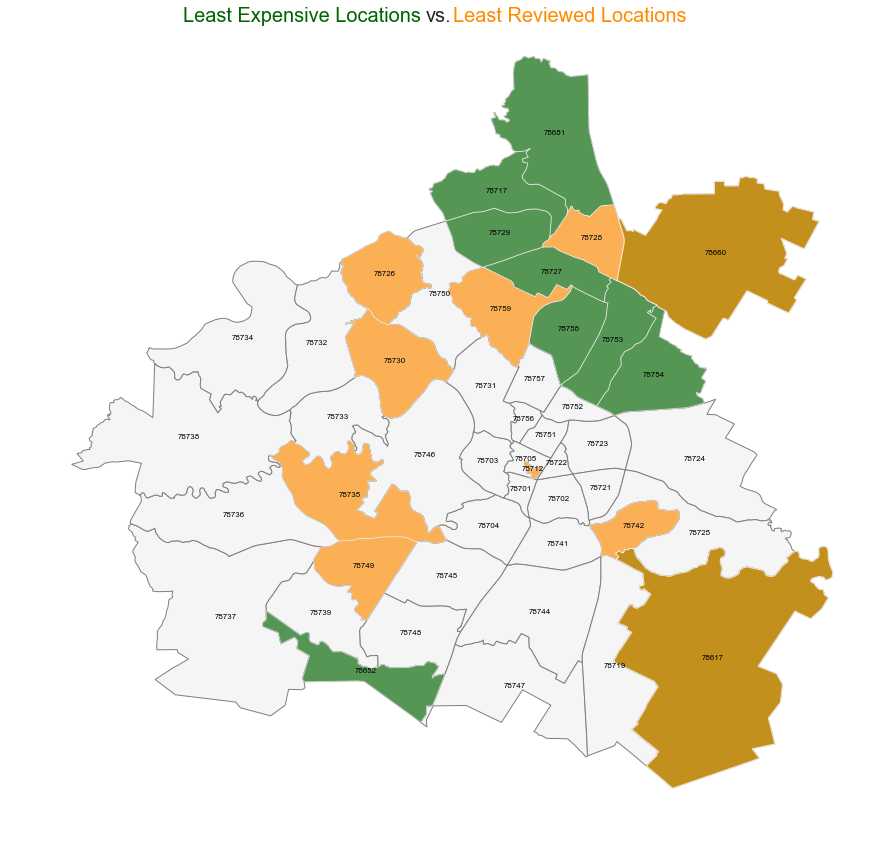

In [82]:
fig, ax = plt.subplots(figsize=(15,15))

base = geo_df.plot(color="whitesmoke", \
                   edgecolor="grey", ax=ax)
geo_df.apply(lambda x: ax.annotate(s=x.name, \
                                   xy=x.geometry.centroid.coords[0], \
                                   ha="center", fontweight="light", \
                                   fontsize=8, color="black"), axis=1)
base.axis("off")

price_df[["geometry", "price"]][-10:].plot(color="darkgreen", alpha=0.65, \
                                           ax=base)

reviews_df[["geometry", "number_of_reviews"]][-10:].plot(color="darkorange", \
                                                         alpha=0.65, ax=base)

fig.text(0.373, 0.870, "Least Expensive Locations", ha="center", \
         va="bottom", size=20,color="darkgreen")
fig.text(0.500, 0.870, "vs.", ha="center", va="bottom", size=20)
fig.text(0.621, 0.870, "Least Reviewed Locations", ha="center", \
         va="bottom", size=20,color="darkorange")

plt.show()

We learn that there are also only two zip codes that happen to be the least expensive and the least reviewed. These are 78660 and 78617.

From the above plots, it can be said that there is a relationship between the number of reviews of a listings and its price – though it's quite weak.

### Crimes and Price ###
Below is the total number of crimes that occurred in every Austin, TX zip code during 2018. This was plotted after aggregating all the crimes in the `crimes` dataset in only the zip codes that are also present in our `listings` dataset.

Since high crime just happens to be an unfortunate byprodut of a bustling city, then a good hypothesis would be: more crime indicates an expensive zip code. Note that we are keeping it simple and are looking at the total number of crimes in *absolute* terms, as a count of how many were reported. We are not looking at *per capita* crime since there are no population data in our datasets.

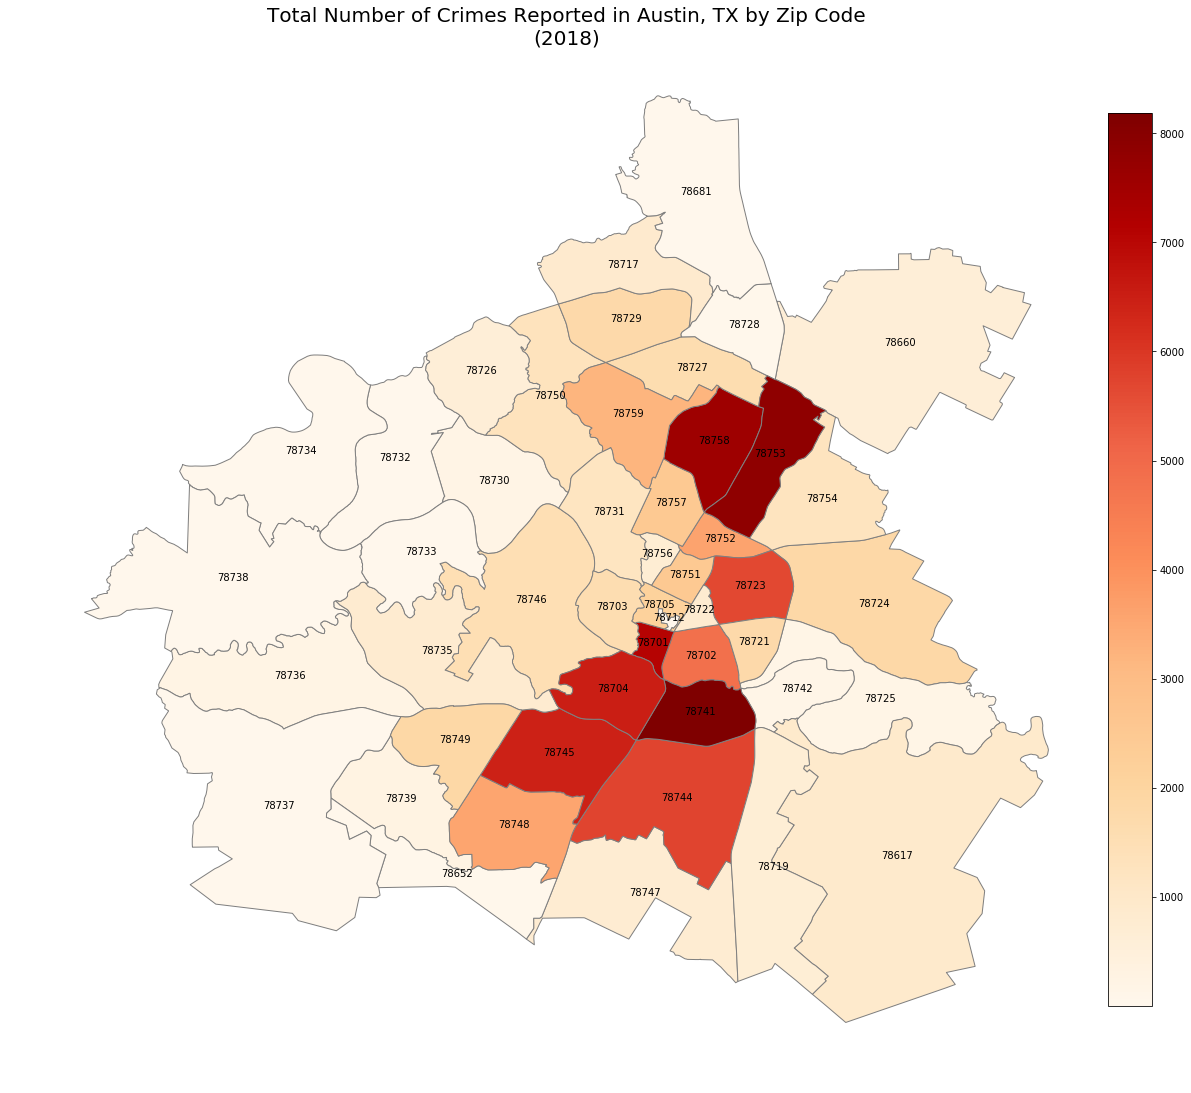

In [62]:
crimes_df = df.drop_duplicates(subset=["zipcode", "Total No. of Crimes"])
crimes_df = crimes_df[["zipcode", "Total No. of Crimes"]]
crimes_df = pd.merge(austin_map, crimes_df, how="right", on="zipcode")
crimes_df = crimes_df.set_index("zipcode")

fig, ax = plt.subplots(figsize=(20,20))

ax = crimes_df.plot(column="Total No. of Crimes", cmap="OrRd", \
                    edgecolor="grey", ax=ax)
crimes_df.apply(lambda x: ax.annotate(s=x.name, \
                                      xy=x.geometry.centroid.coords[0], \
                                      ha="center", fontweight="ultralight", \
                                      color="black"), axis=1)
ax.axis("off")

min_crimes = crimes_df["Total No. of Crimes"].min()
max_crimes = crimes_df["Total No. of Crimes"].max()

gradient = plt.cm.ScalarMappable(cmap="OrRd", \
                            norm=plt.Normalize(vmin=min_crimes, \
                                               vmax=max_crimes))
gradient._A = []
plt.colorbar(gradient, fraction=0.04, pad=.01)

plt.title("Total Number of Crimes Reported in Austin, TX by Zip Code\n(2018)", \
          fontdict={"fontsize":20})

plt.show()

We can test the relationshop of high crime and high price by plotting the top 10 most expensive Airbnb zip codes (*in green*) along with the top 10 locations with the most crime (*in red*). We see that there is only one intersection, 78701, in maroon.

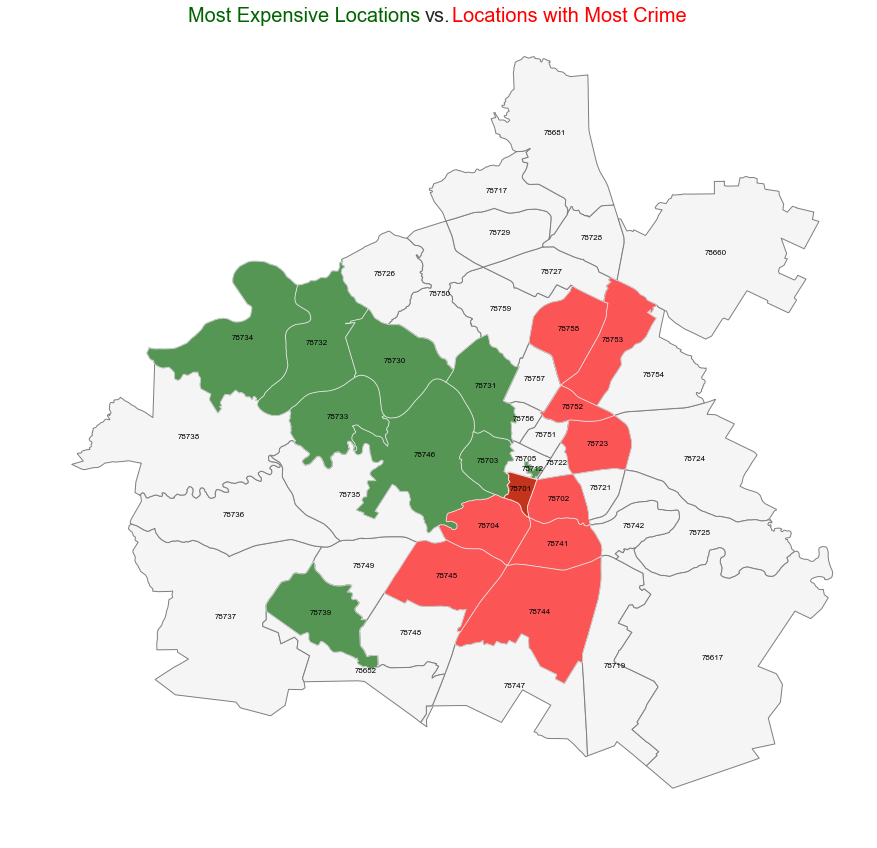

In [83]:
crimes_df = df.drop_duplicates(subset=["zipcode", "Total No. of Crimes"])
crimes_df = crimes_df[["zipcode", "Total No. of Crimes"]]
crimes_df = pd.merge(austin_map, crimes_df, how="right", on="zipcode")
crimes_df = crimes_df.sort_values("Total No. of Crimes", ascending=False)
crimes_df = crimes_df[["zipcode", "geometry", \
                       "Total No. of Crimes"]].set_index("zipcode")

price_df = df.pivot_table(index="zipcode", values="price", aggfunc="mean")
price_df = pd.merge(austin_map, price_df, how="right", on="zipcode")
price_df = price_df.sort_values("price", ascending=False)
price_df = price_df[["zipcode", "geometry", "price"]].set_index("zipcode")

geo_df = listings_df.groupby("zipcode").count()
geo_df = pd.merge(austin_map, geo_df, how="right", on="zipcode")
geo_df = geo_df.sort_values("id", ascending=False)
geo_df = geo_df[["zipcode", "geometry", "id"]].set_index("zipcode")

fig, ax = plt.subplots(figsize=(15,15))

base = geo_df.plot(color="whitesmoke", \
                   edgecolor="grey", ax=ax)
geo_df.apply(lambda x: ax.annotate(s=x.name, \
                                   xy=x.geometry.centroid.coords[0], \
                                   ha="center", fontweight="light",
                                   fontsize=8, color="black"), axis=1)
base.axis("off")

price_df[["geometry", "price"]][0:10].plot(color="darkgreen", \
                                           alpha=0.65, ax=base)

crimes_df[["geometry", "Total No. of Crimes"]][0:10].plot(color="red", \
                                                          alpha=0.65, ax=base)

fig.text(0.375, 0.870, "Most Expensive Locations", ha="center", \
         va="bottom", size=20,color="darkgreen")
fig.text(0.499, 0.870, "vs.", ha="center", va="bottom", size=20)
fig.text(0.621, 0.870, "Locations with Most Crime", ha="center", \
         va="bottom", size=20,color="red")

plt.show()

The opposite can also test the relationship: this is by plotting the top ten with the least crimes against the top ten least expensive places. Again, there isn't much in terms of intersection, with only two zip codes that coincide: 78681 and 78652.

This then tells us that high crime doesn't necessarily mean higher price. Perhaps because crime may not be a concern for a guest that has already decided to book a place in Austin, TX, especially if the crime rate isn't dire enough to stave off tourism.

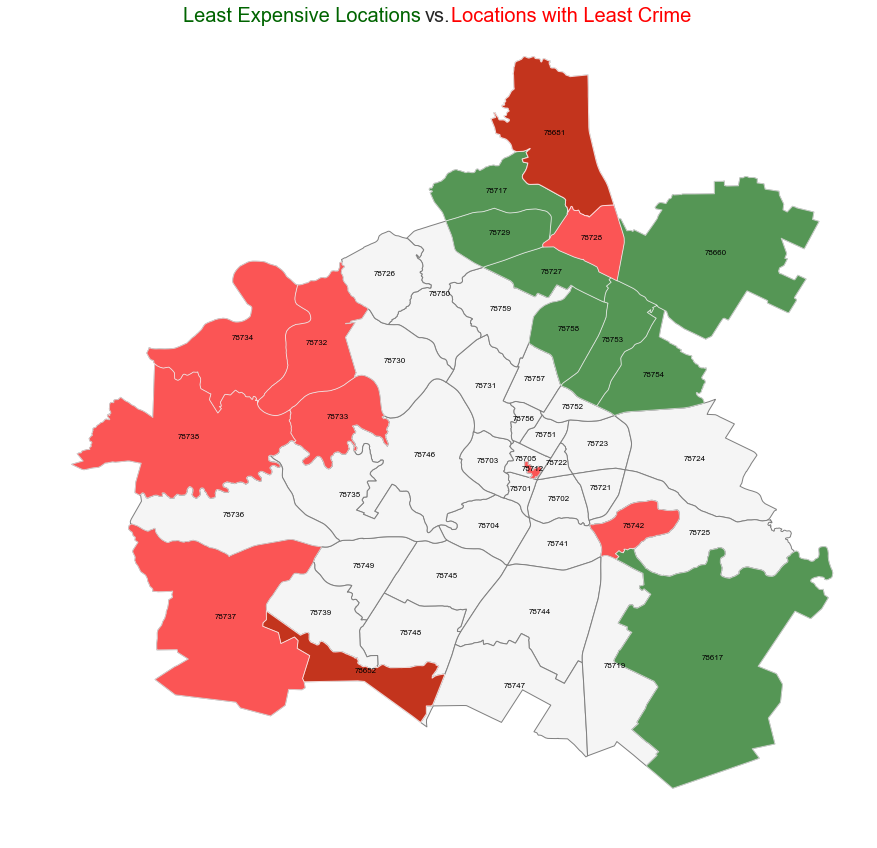

In [84]:
fig, ax = plt.subplots(figsize=(15,15))

base = geo_df.plot(color="whitesmoke", \
                   edgecolor="grey", ax=ax)
geo_df.apply(lambda x: ax.annotate(s=x.name, \
                                   xy=x.geometry.centroid.coords[0], \
                                   ha="center", fontweight="light", \
                                   fontsize=8, color="black"), axis=1)
base.axis("off")

price_df[["geometry", "price"]][-10:].plot(color="darkgreen", alpha=0.65, \
                                           ax=base)

crimes_df[["geometry", "Total No. of Crimes"]][-10:].plot(color="red", \
                                                          alpha=0.65, ax=base)

fig.text(0.373, 0.870, "Least Expensive Locations", ha="center", \
         va="bottom", size=20,color="darkgreen")
fig.text(0.499, 0.870, "vs.", ha="center", va="bottom", size=20)
fig.text(0.623, 0.870, "Locations with Least Crime", ha="center", \
         va="bottom", size=20,color="red")

plt.show()

### Distribution of Categorical Data ###
A lot of the features of our final `df` dataframe are discrete with minimal range of values. If we group the distribution of price per a categorical feature's range of values and plot them in a boxplot, we would be able to visually *infer* if the feature would be able to predict our dependent variable, *price*.

The figures below characterize the listing in terms of its host. As we see, `host_identity_verified` shows almost no variability across its two categories and that `1` is only *slightly* different from `0` in terms of spread. That tells us that this is not a good predictor for our model.

On the other hand, `host_is_superhost` is more characterizing as there is a noticable shift.

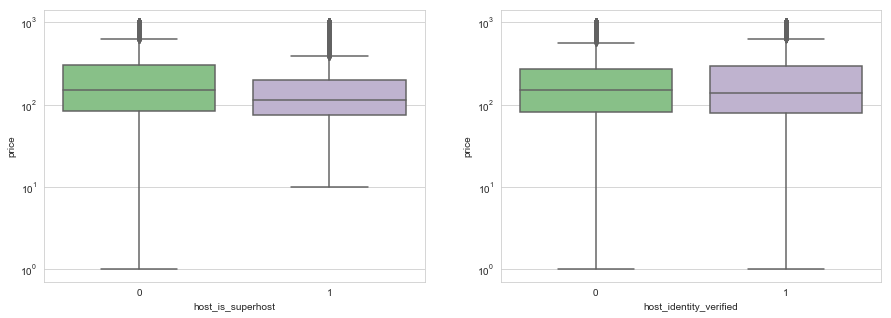

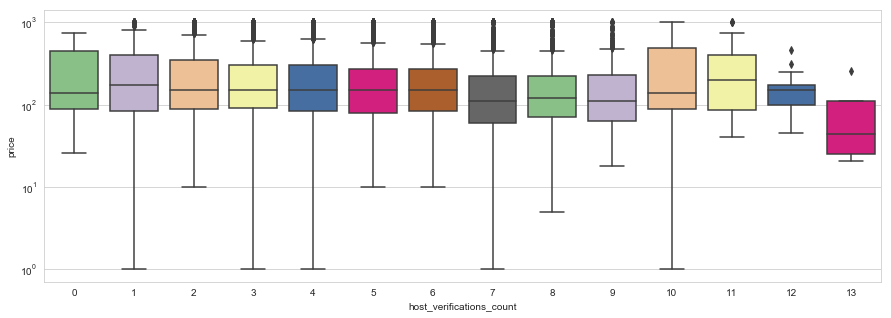

In [65]:
sns.set_style("whitegrid")

f, axes = plt.subplots(1, 2, figsize=(15,5))
ax = sns.boxplot(data=df, x="host_is_superhost", y="price", \
                 palette="Accent", ax=axes[0])
ax.set(yscale="log")
ax = sns.boxplot(data=df, x="host_identity_verified", y="price", \
                 palette="Accent", ax=axes[1])
ax.set(yscale="log")
plt.show()

f, axes = plt.subplots(figsize=(15,5))
ax = sns.boxplot(data=df, x="host_verifications_count", y="price", \
                 palette="Accent")
ax.set(yscale="log")
plt.show()

The next set of features look at the categorical columns of listings in terms of their nature. The `room_type` is a very good candidate for our model because of how distinct each of its value is. It is immediately clear from the figure that entire houses are more affordable than private rooms, and even more so than with shared rooms.

The `cancellation_policy` boxplots show us that the most expensive places have the strictest booking policies.

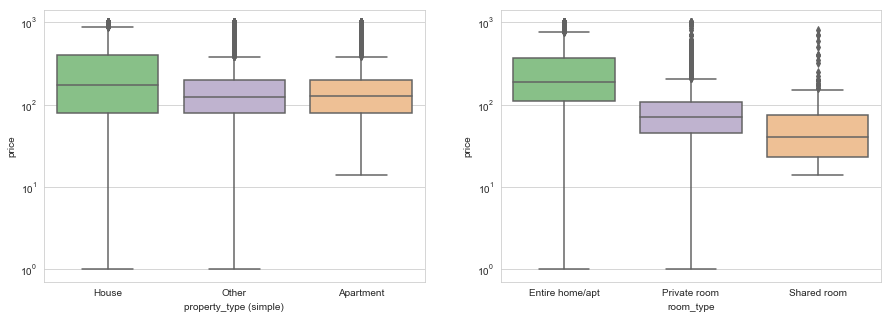

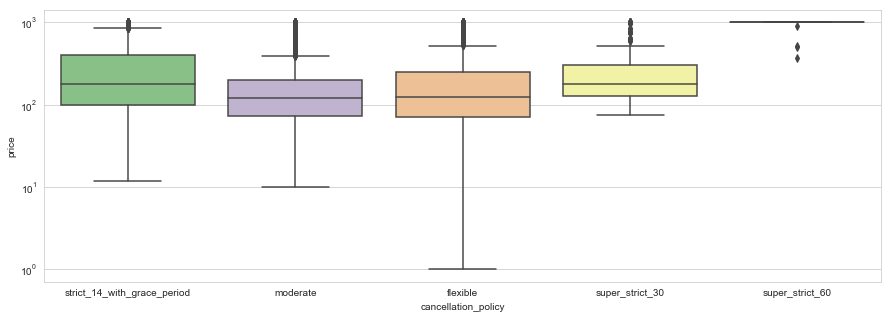

In [66]:
sns.set_style("whitegrid")

f, axes = plt.subplots(1, 2, figsize=(15,5))
ax = sns.boxplot(data=df, x="property_type (simple)", y="price", \
                 palette="Accent", ax=axes[0])
ax.set(yscale="log")
ax = sns.boxplot(data=df, x="room_type", y="price", \
                 palette="Accent", ax=axes[1])
ax.set(yscale="log")
plt.show()

f, axes = plt.subplots(figsize=(15,5))
ax = sns.boxplot(data=df, x="cancellation_policy", y="price", \
                 palette="Accent")
ax.set(yscale="log")
plt.show()

The next batch of features are the categories that were generated from the listings' `amenities`. Here, it makes it evident that `Family-friendly` places tend to be costlier than those that are not (or those that do not specify that they are). Perhaps these listings are able to accommodate more headcount or perhaps these tend to be in quieter neighborhoods and hence are generally more expensive.

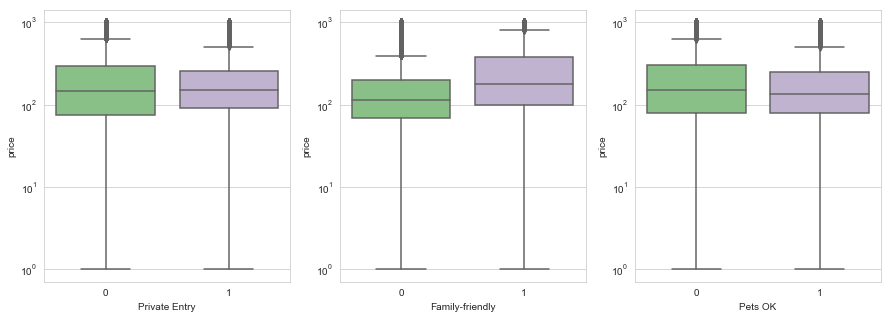

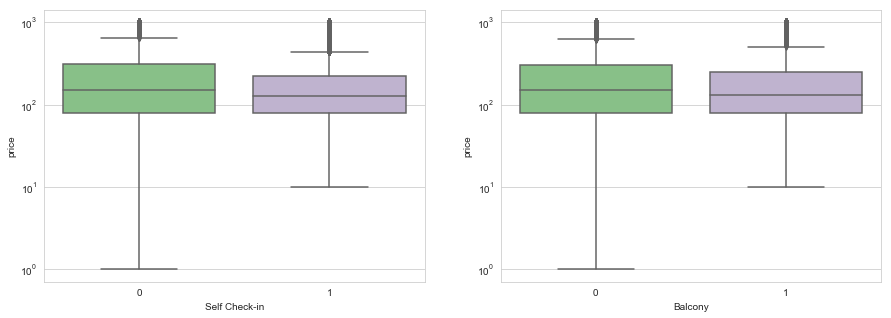

In [67]:
sns.set_style("whitegrid")

f, axes = plt.subplots(1, 3, figsize=(15,5))
ax = sns.boxplot(data=df, x="Private Entry", y="price", \
                 palette="Accent", ax=axes[0])
ax.set(yscale="log")
ax = sns.boxplot(data=df, x="Family-friendly", y="price", \
                 palette="Accent", ax=axes[1])
ax.set(yscale="log")
ax = sns.boxplot(data=df, x="Pets OK", y="price", \
                 palette="Accent", ax=axes[2])
ax.set(yscale="log")
plt.show()

f, axes = plt.subplots(1, 2, figsize=(15,5))
ax = sns.boxplot(data=df, x="Self Check-in", y="price", \
                 palette="Accent", ax=axes[0])
ax.set(yscale="log")
ax = sns.boxplot(data=df, x="Balcony", y="price", \
                 palette="Accent", ax=axes[1])
ax.set(yscale="log")
plt.show()

The `minimum nights` feature also shows distinction per classification. It's quite intuitive to assume that places that allow shorter-term stays would be pricier (like in the terms of lease in most apartments), but somehow this is not the case here. The pricing in terms of this feature is more varied.

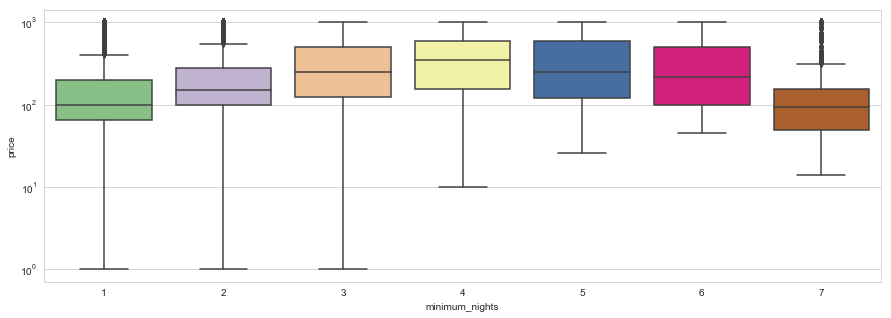

In [68]:
sns.set_style("whitegrid")

f, axes = plt.subplots(figsize=(15,5))
ax = sns.boxplot(data=df, x="minimum_nights", y="price", \
                 palette="Accent")
ax.set(yscale="log")
plt.show()

The `accommodates` and the `guests_included` features both give us a sense of how large a listing is. For the former, a smaller listing would only be able to accommodate fewer people and therefore the lower the number is, the cheaper. For the latter, if more headcount can be accommodated without extra charge, then that suggests these extra people are already *priced in* on the nightly rate, and are therefore more expensive.

These takeaways can be inferred from the plots below.

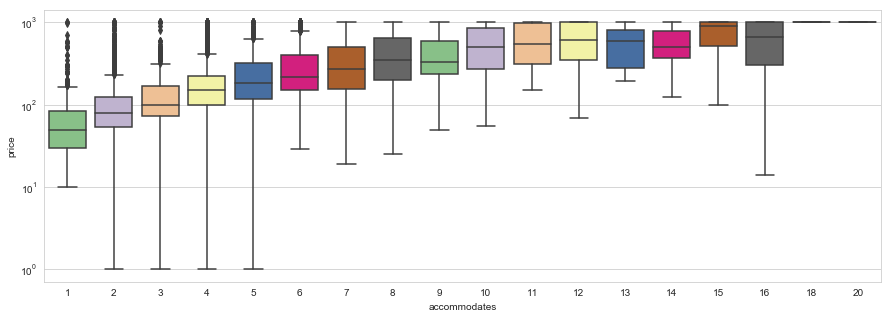

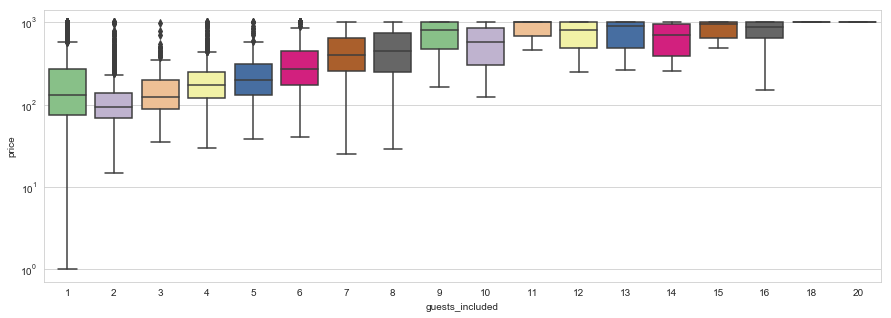

In [69]:
sns.set_style("whitegrid")

f, axes = plt.subplots(1, 1, figsize=(15,5))
ax = sns.boxplot(data=df, x="accommodates", y="price", \
                 palette="Accent")
ax.set(yscale="log")
plt.show()

f, axes = plt.subplots(1, 1, figsize=(15,5))
ax = sns.boxplot(data=df, x="guests_included", y="price", \
                 palette="Accent")
ax.set(yscale="log")
plt.show()